### Want to see if the decoding axes from correct or incorrect feature decoders are negatively correlated (cos(theta) < 0)

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

import scipy


In [3]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
FEAT_1 = "SQUARE"
FEAT_2 = "TRIANGLE"
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FeedbackOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"

### setup

In [4]:
feature_dim_to_str = {
    "Color": "CYAN_vs_GREEN_vs_MAGENTA_vs_YELLOW",
    "Shape": "SQUARE_vs_TRIANGLE_vs_CIRCLE_vs_STAR",
    "Pattern": "ESCHER_vs_POLKADOT_vs_RIPPLE_vs_SWIRL",
}
num_time_bins = 56
num_features = 12
num_units = 756
num_splits = 8

### Cosine similarity across cor/inc
NOTE: if z-scoring weight vectors, cosine similarity is the same as Pearson's correlation 

In [ ]:
# plot by time: 
# for each feature: 
cosine_sims = np.empty((num_time_bins, num_features))
for feature_dim_idx, feature_dim in enumerate(FEATURE_DIMS): 
    feature_str = feature_dim_to_str[feature_dim]
    cor_model = np.load(
        os.path.join(OUTPUT_DIR, f"{feature_str}_Response_Correct_residual_fr_unshuffled_models.npy"), 
        allow_pickle=True
    )
    inc_model = np.load(
        os.path.join(OUTPUT_DIR, f"{feature_str}_Response_Incorrect_residual_fr_unshuffled_models.npy"), 
        allow_pickle=True
    )
    for time_idx in range(num_time_bins):
        for feature_idx in range(4):
            cor_vecs = np.empty((num_units, num_splits))
            inc_vecs = np.empty((num_units, num_splits))
            for split_idx in range(num_splits):
                cor_vecs[:, split_idx] = cor_model[time_idx, split_idx].coef_[feature_idx, :]
                inc_vecs[:, split_idx] = inc_model[time_idx, split_idx].coef_[feature_idx, :]
            avg_cor_vec = np.mean(cor_vecs, axis=1)
            avg_inc_vec = np.mean(inc_vecs, axis=1)
            # print(np.mean(avg_cor_vec))
            # print(np.mean(avg_inc_vec))
            # avg_cor_vec = np.mean(cor_vecs, axis=1) - np.mean(cor_vecs)
            # avg_inc_vec = np.mean(inc_vecs, axis=1)- np.mean(inc_vecs)
            cos_sim = np.dot(avg_cor_vec, avg_inc_vec) / (np.linalg.norm(avg_cor_vec) * np.linalg.norm(avg_inc_vec))
            cosine_sims[time_idx, feature_dim_idx * 4 + feature_idx] = cos_sim


Text(0.5, 0, 'Time Relative to Feedback (s)')

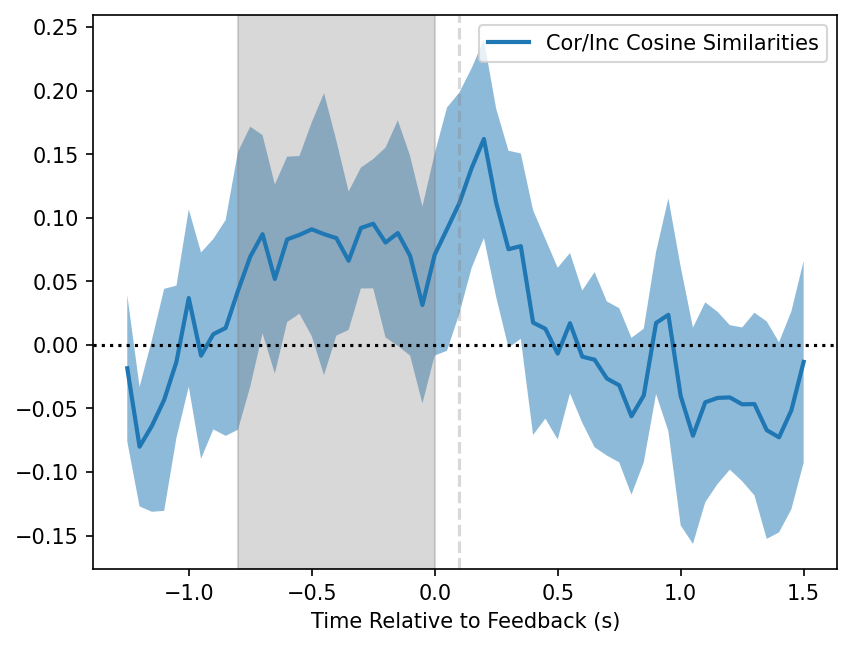

In [21]:
fig, ax = plt.subplots(dpi=150)
visualization_utils.visualize_accuracy_across_time_bins(
    cosine_sims,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="Cor/Inc Cosine Similarities",
    right_align=True, 
    # sem=True,
)
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.0, color='black', linestyle='dotted', label="Orth")
ax.set_xlabel("Time Relative to Feedback (s)")
# ax.set_ylabel("Decoder Accuracy")

### How stable are these axes across time? Cosine sim across time, within cor and inc

In [8]:
# plot by time: 
# for each feature: 
responses = ["Correct", "Incorrect"]
response_sims = []
for response in responses:
    cosine_sims = np.empty((num_time_bins, num_time_bins, num_features))
    for feature_dim_idx, feature_dim in enumerate(FEATURE_DIMS): 
        feature_str = feature_dim_to_str[feature_dim]
        model = np.load(
            os.path.join(OUTPUT_DIR, f"{feature_str}_Response_{response}_residual_fr_unshuffled_models.npy"), 
            allow_pickle=True
        )
        for time_idx_i in range(num_time_bins):
            for time_idx_j in range(num_time_bins):
                for feature_idx in range(4):
                    i_vecs = np.empty((num_units, num_splits))
                    j_vecs = np.empty((num_units, num_splits))
                    for split_idx in range(num_splits):
                        i_vecs[:, split_idx] = model[time_idx_i, split_idx].coef_[feature_idx, :]
                        j_vecs[:, split_idx] = model[time_idx_j, split_idx].coef_[feature_idx, :]
                    avg_i_vec = np.mean(i_vecs, axis=1)
                    avg_j_vec = np.mean(j_vecs, axis=1)
                    cos_sim = np.dot(avg_i_vec, avg_j_vec) / (np.linalg.norm(avg_i_vec) * np.linalg.norm(avg_j_vec))
                    cosine_sims[time_idx_i, time_idx_j, feature_dim_idx * 4 + feature_idx] = cos_sim
    cosine_sims = np.mean(cosine_sims, axis=2)
    response_sims.append(cosine_sims)

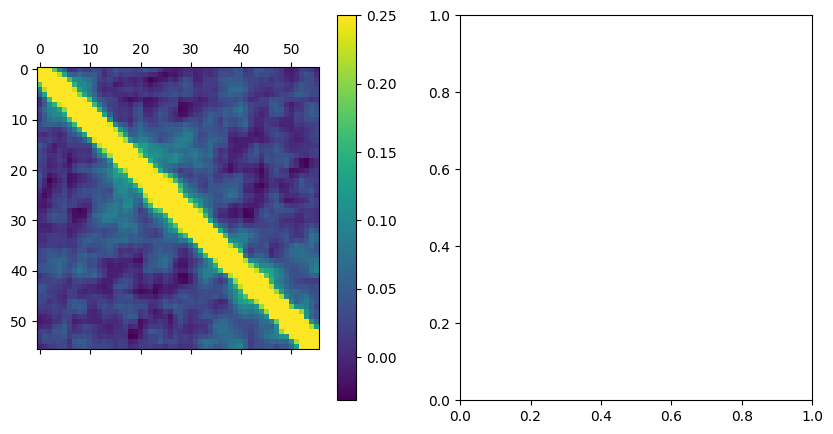

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = ax[0].matshow(response_sims[0])
fig.colorbar(colors, ax=ax[0])
colors.set_clim(vmax=0.25)